# Step 1 - Clone the Github repo

In [1]:
!rm -rf sonic-mood # force remove the cloned repo if it already exists (this ensures we always clone successfully and can get the latest code)
!git clone https://github.com/Electronic-Yoda/sonic-mood.git

Cloning into 'sonic-mood'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 162 (delta 81), reused 90 (delta 38), pack-reused 0
Receiving objects: 100% (162/162), 715.08 KiB | 10.67 MiB/s, done.
Resolving deltas: 100% (81/81), done.


You should see the repository cloned into sonic-mood directory. 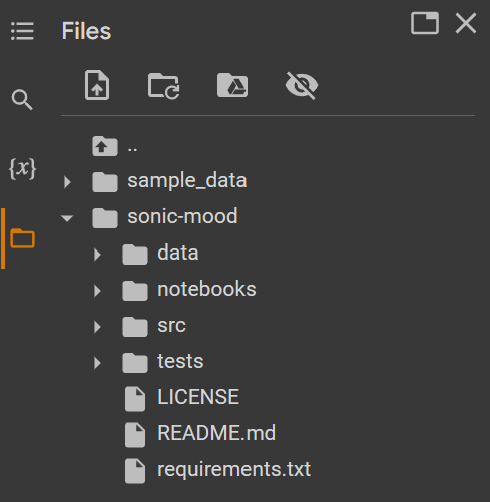

# Step 2 - add the GITHUB_REPO_PATH to Colab's Python path so we can import necessary modules.

In [2]:
GITHUB_REPO_PATH = 'sonic-mood'

import sys, os
sys.path.insert(0, GITHUB_REPO_PATH)

After this is done, you can import every python module in sonic-mood

In [3]:
from src.utils.dataset import MelspecEmotionDataset
from src.utils.constants import Columns, Emotions, Datasets
import src.utils.data_processing as data_processing

# Step 3 - Using datasets

In [4]:
# import google drive so we have access to the raw audio data stored there
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
APS360_DRIVE_PATH = '/content/gdrive/MyDrive/APS360_Project_Group/'


Mounted at /content/gdrive


In [5]:
import pandas as pd
import torch
# import csvs used for training, validation, and testing
train_df = data_processing.read_csv(
    pd.read_csv(
        os.path.join(GITHUB_REPO_PATH, '/content/train_melspec_8.csv'),
        index_col=False
    ),
    APS360_DRIVE_PATH
)
val_df = data_processing.read_csv(
    pd.read_csv(
        os.path.join(GITHUB_REPO_PATH, '/content/val_melspec_8.csv'),
        index_col=False
    ),
    APS360_DRIVE_PATH
)
test_df = data_processing.read_csv(
    pd.read_csv(
        os.path.join(GITHUB_REPO_PATH, '/content/test_melspec_8.csv'),
        index_col=False
    ),
    APS360_DRIVE_PATH
)

# Create datasets.
train_ds = MelspecEmotionDataset(train_df)
val_ds = MelspecEmotionDataset(val_df)
test_ds = MelspecEmotionDataset(test_df)



In [6]:
# Create dataloaders
batch_size = 20
num_workers = 8
pin_memory = True
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
mini_train = torch.utils.data.Subset(train_ds,list(range(0, len(train_ds), 16)))
mini_train_loader = torch.utils.data.DataLoader(mini_train, batch_size=batch_size, num_workers=2, shuffle=True)

mini_val = torch.utils.data.Subset(val_ds,list(range(0, len(val_ds), 16)))
mini_val_loader = torch.utils.data.DataLoader(mini_val, batch_size=batch_size, num_workers=2, shuffle=True)

mini_test = torch.utils.data.Subset(train_ds,list(range(0, len(test_ds), 16)))
mini_test_loader = torch.utils.data.DataLoader(mini_test, batch_size=batch_size, num_workers=2, shuffle=True)

In [8]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

print(len(mini_train_loader))
print(len(mini_val_loader))
print(len(mini_test_loader))

531
114
114
34
8
8


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import math

import torch.optim as optim
import numpy as np
import time

class AudioCNN(nn.Module):
    def __init__(self, kernel_dimensions = [5, 3, 3], stride_sizes = [4, 1, 1], padding_sizes = [1, 1, 1]):
        super().__init__()
        self.name = 'AudioCNN'

        input_dimension_x = 64
        input_dimension_y = 292
        pool_kernel_dimension = 3
        pool_stride_size = 2
        out_channels = 512

        self.conv1 = nn.Conv2d(1, 32, kernel_dimensions[0], stride=stride_sizes[0], padding=padding_sizes[0])
        self.conv2 = nn.Conv2d(32, 64,  kernel_dimensions[1], stride=stride_sizes[1], padding=padding_sizes[1])
        self.conv3 = nn.Conv2d(64, 128,  kernel_dimensions[2], stride=stride_sizes[2], padding=padding_sizes[2])
        self.conv4 = nn.Conv2d(128, 256,  kernel_dimensions[2], stride=stride_sizes[2], padding=padding_sizes[2])
        self.conv5 = nn.Conv2d(256, out_channels,  kernel_dimensions[2], stride=stride_sizes[2], padding=padding_sizes[2])
        self.pool = nn.MaxPool2d(pool_kernel_dimension, pool_stride_size)

        oc1_x = math.floor((input_dimension_x + 2 * padding_sizes[0]- kernel_dimensions[0]) / stride_sizes[0]) + 1
        op1_x = math.floor((oc1_x - pool_kernel_dimension) / pool_stride_size) + 1
        oc2_x = math.floor((op1_x + 2 * padding_sizes[1] - kernel_dimensions[1]) / stride_sizes[1]) + 1
        op2_x = math.floor((oc2_x - pool_kernel_dimension) / pool_stride_size) + 1
        oc3_x = math.floor((op2_x + 2 * padding_sizes[2] - kernel_dimensions[2]) / stride_sizes[2]) + 1
        oc4_x = math.floor((oc3_x + 2 * padding_sizes[2] - kernel_dimensions[2]) / stride_sizes[2]) + 1
        oc5_x = math.floor((oc4_x + 2 * padding_sizes[2] - kernel_dimensions[2]) / stride_sizes[2]) + 1
        o_x = math.floor((oc5_x - pool_kernel_dimension) / pool_stride_size) + 1

        oc1_y = math.floor((input_dimension_y + 2 * padding_sizes[0]- kernel_dimensions[0]) / stride_sizes[0]) + 1
        op1_y = math.floor((oc1_y - pool_kernel_dimension) / pool_stride_size) + 1
        oc2_y = math.floor((op1_y + 2 * padding_sizes[1] - kernel_dimensions[1]) / stride_sizes[1]) + 1
        op2_y = math.floor((oc2_y - pool_kernel_dimension) / pool_stride_size) + 1
        oc3_y = math.floor((op2_y + 2 * padding_sizes[2] - kernel_dimensions[2]) / stride_sizes[2]) + 1
        oc4_y = math.floor((oc3_y + 2 * padding_sizes[2] - kernel_dimensions[2]) / stride_sizes[2]) + 1
        oc5_y = math.floor((oc4_y + 2 * padding_sizes[2] - kernel_dimensions[2]) / stride_sizes[2]) + 1
        o_y = math.floor((oc5_y - pool_kernel_dimension) / pool_stride_size) + 1
        self.fc_input_size = out_channels * o_x * o_y

        self.fc1 = nn.Linear(self.fc_input_size, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 8)

    def forward(self, x):
        # c1 + p1
        x = self.pool(torch.relu(self.conv1(x)))
        # c2 + p2
        x = self.pool(torch.relu(self.conv2(x)))
        # c3, c4
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        # c5 + p3
        x = self.pool(torch.relu(self.conv5(x)))
        # print(self.fc_input_size)
        x = x.view(-1, self.fc_input_size)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
def train_net(net, train_loader, val_loader, batch_size=32, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Loss fn and Optimizer
    criterion = nn.CrossEntropyLoss() # CE, for k classes (in this case k = 8)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate) # Adam optimizer
    ########################################################################
    # Training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Training
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset num_epochs times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0

        for i, data in tqdm(enumerate(train_loader, 0)):
            # print("Loader",i)
            inputs, labels = data # Get the inputs
            if torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
            optimizer.zero_grad() # Zero the parameter gradients
            outputs = net(inputs) # forwards
            loss = criterion(outputs, labels) # compute loss
            loss.backward() # backwards
            optimizer.step() # optimizer
            total_train_loss += loss.item()

        train_err[epoch] = get_error(net, train_loader)
        train_loss[epoch] = float(total_train_loss) / (len(train_loader))
        val_err[epoch] = get_error(net, val_loader)
        val_loss[epoch] = get_loss(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


##########################################
# Evaluation Functions

def get_error(model, data_loader):
    correct = 0
    total = 0
    eval_mod = model.eval()
    for inputs, labels in data_loader:
        if torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
        out = eval_mod(inputs)
        #select index with maximum prediction score
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += inputs.shape[0]
    return (total-correct) / total

def get_loss(model, data_loader, criterion):
    loss = 0.0
    total_loss = 0.0
    eval_mod = model.eval()
    for inputs, labels in data_loader:
      if torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
      out = eval_mod(inputs)
      loss = criterion(out, labels)
      total_loss += loss.item()

    loss = float(total_loss) / (len(data_loader))
    return loss


########################################################################
# Helper fns from lab 2
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        for data_i,datapoint in enumerate(outputs):
              pred = torch.argmax(datapoint)
              # print(pred)
              # print(labels[data_i])
              if pred != labels[data_i]:
                # print("Wrong pred!")
                total_err += 1
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [13]:
net = AudioCNN()
if torch.cuda.is_available():
  print("CUDA AVAILABLE")
  net.cuda()
train_net(net, train_loader, val_loader, batch_size= 500, learning_rate=1e-6,num_epochs=22)

531it [03:07,  2.84it/s]


Epoch 1: Train err: 0.6916336913510458, Train loss: 2.0397297224756015 |Validation err: 0.7059859154929577, Validation loss: 1.9989269856821026


531it [03:05,  2.86it/s]


Epoch 2: Train err: 0.638496325607688, Train loss: 1.9416010155291656 |Validation err: 0.6443661971830986, Validation loss: 1.8767801920572917


531it [03:08,  2.81it/s]


Epoch 3: Train err: 0.6147540983606558, Train loss: 1.8112743590062172 |Validation err: 0.6227992957746479, Validation loss: 1.7587600036671287


531it [03:10,  2.79it/s]


Epoch 4: Train err: 0.5969474279253816, Train loss: 1.699885603398253 |Validation err: 0.6087147887323944, Validation loss: 1.6608817911984628


531it [03:21,  2.64it/s]


Epoch 5: Train err: 0.5708498209911438, Train loss: 1.6180039222182079 |Validation err: 0.5787852112676056, Validation loss: 1.5930408281192445


531it [03:21,  2.64it/s]


Epoch 6: Train err: 0.5591671377426041, Train loss: 1.5606201920805678 |Validation err: 0.5691021126760564, Validation loss: 1.5458642892670214


531it [03:12,  2.75it/s]


Epoch 7: Train err: 0.5488976823063878, Train loss: 1.5184960351825434 |Validation err: 0.5598591549295775, Validation loss: 1.5108569118014552


531it [03:19,  2.67it/s]


Epoch 8: Train err: 0.5388166572451479, Train loss: 1.4862811329674586 |Validation err: 0.539612676056338, Validation loss: 1.483916649692937


531it [03:09,  2.80it/s]


Epoch 9: Train err: 0.5303372903712078, Train loss: 1.4621467911366464 |Validation err: 0.53125, Validation loss: 1.464048723379771


531it [03:08,  2.81it/s]


Epoch 10: Train err: 0.5256265309967967, Train loss: 1.440602933844155 |Validation err: 0.5290492957746479, Validation loss: 1.4448085092661673


531it [03:11,  2.77it/s]


Epoch 11: Train err: 0.51856039193518, Train loss: 1.4219832295751842 |Validation err: 0.5272887323943662, Validation loss: 1.4253533853773486


531it [03:14,  2.74it/s]


Epoch 12: Train err: 0.5146975692481628, Train loss: 1.4066913181779075 |Validation err: 0.5202464788732394, Validation loss: 1.4136291052165784


531it [03:13,  2.74it/s]


Epoch 13: Train err: 0.5141322781232335, Train loss: 1.3914146973363872 |Validation err: 0.5184859154929577, Validation loss: 1.3992341113717932


531it [03:15,  2.71it/s]


Epoch 14: Train err: 0.5049934049368758, Train loss: 1.3777504711501343 |Validation err: 0.5136443661971831, Validation loss: 1.386238742292973


531it [03:20,  2.65it/s]


Epoch 15: Train err: 0.510552100998681, Train loss: 1.3651585398196275 |Validation err: 0.5180457746478874, Validation loss: 1.3770537360718376


531it [03:10,  2.79it/s]


Epoch 16: Train err: 0.4959487469380064, Train loss: 1.3550473699686443 |Validation err: 0.5044014084507042, Validation loss: 1.362712836056425


531it [03:14,  2.73it/s]


Epoch 17: Train err: 0.49208592425098924, Train loss: 1.3422235351497844 |Validation err: 0.49691901408450706, Validation loss: 1.3511174472800471


531it [03:09,  2.80it/s]


Epoch 18: Train err: 0.4917090635010364, Train loss: 1.3335303308375586 |Validation err: 0.4942781690140845, Validation loss: 1.3436249316784374


531it [03:10,  2.79it/s]


Epoch 19: Train err: 0.4804032410024496, Train loss: 1.3236568416354795 |Validation err: 0.47975352112676056, Validation loss: 1.3373199194146876


531it [03:17,  2.69it/s]


Epoch 20: Train err: 0.48671565856416055, Train loss: 1.3140132779679954 |Validation err: 0.49559859154929575, Validation loss: 1.3276869241605724


531it [03:13,  2.74it/s]


Epoch 21: Train err: 0.4750329753156209, Train loss: 1.3057487989774084 |Validation err: 0.4793133802816901, Validation loss: 1.3196996016460552


531it [03:06,  2.85it/s]


Epoch 22: Train err: 0.4758809120030149, Train loss: 1.2974203124558186 |Validation err: 0.480193661971831, Validation loss: 1.3135313705394143
Finished Training
Total time elapsed: 6198.34 seconds


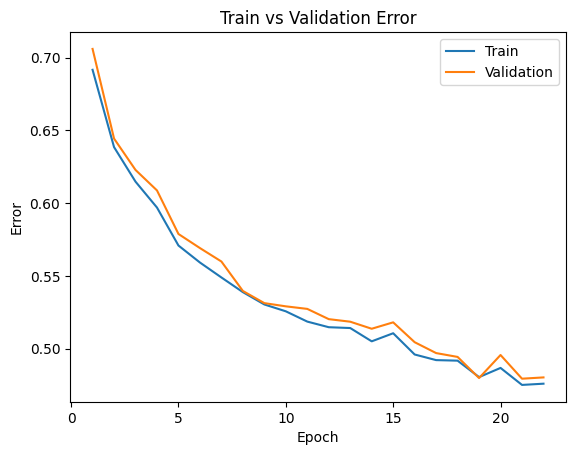

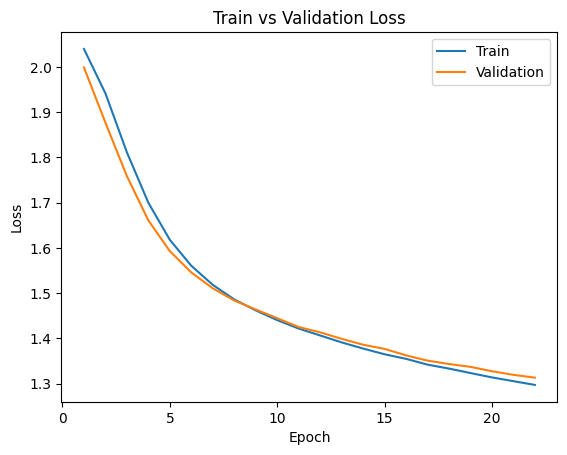

In [17]:
model_path = get_model_name("AudioCNN", batch_size= 500, learning_rate=1e-6, epoch=21)
plot_training_curve(model_path)

In [18]:
def get_class_acc(model, data_loader):
    # 8 classes
    #[0, 1, 2, 3, 4, 5, 6, 7]
    classes = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']

    class_count = [0,0,0,0,0,0,0,0]
    class_corr_preds = [0,0,0,0,0,0,0,0]
    eval_mod = model.eval()
    for inputs, labels in data_loader:
        # Predictions done
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        out = eval_mod(inputs)

        preds = torch.argmax(out,axis=1)

        # Update class count + correct count
        # Iterating over each data piece in the batch
        # print(labels)
        # print(preds)
        # print("---------")
        for i in range (len(labels)):
            # argmax(out[i]) # pred
            # labels[i] = true label
            class_count[labels[i]] += 1
            if labels[i] == preds[i]:
                class_corr_preds[labels[i]] += 1

    # Get class accuracies
    class_acc = []
    for i in range(len(classes)):
        class_acc.append(class_corr_preds[i]/class_count[i])
    print("CLASS ACCURACIES:",class_acc)
    return class_acc


In [ ]:
get_class_acc(model, data_loader)

Initial iteration: 20 epochs, lr 0.001, batch size 16, mini train + mini val loaders
Iteration 1: 30 epochs, lr 0.001, batch size 16, train + val loaders
Iteration 2: 20 epochs, lr 0.001, batch size 16, train + val loaders (TRY NEW ARCHITECTURE; reduce pooling 4,4 -> 2,2, hidden layer 500 -> 100)
Iteration 3: 20 epochs, lr 0.001, batch size 16, train + val loaders (TRY NEW ARCHITECTURE; additional fc lin layer for more params to train) **LATEST/BEST MODEL

# Dimensions
The dimensions of your inputs will be (batch size, number of channels, number of Mel frequency bands, number of frames over time), i.e., (N, C, n_mels, T). For Mel-spectrogram, number of channels is just 1.

The dimension of the labels is just (batch size). Each element of the tensor is an integer representing a specific emotion. The integer ranges from 0 to 7. See the example below if you want to convert the integer into its string representation.

In [ ]:
# Note, we can convert labels from integers to strings using Emotions().from_index(emotion_int)
from src.utils.constants import Emotions

# say we have a list of emotions integers from 0 to 7
emotions_integers = [0, 1, 2, 3, 4, 5, 6, 7]
emotions_strings = []
for emotion_int in emotions_integers:
    emotions_strings.append(Emotions().from_index(emotion_int))

print(emotions_integers)
print(emotions_strings)

1e-6

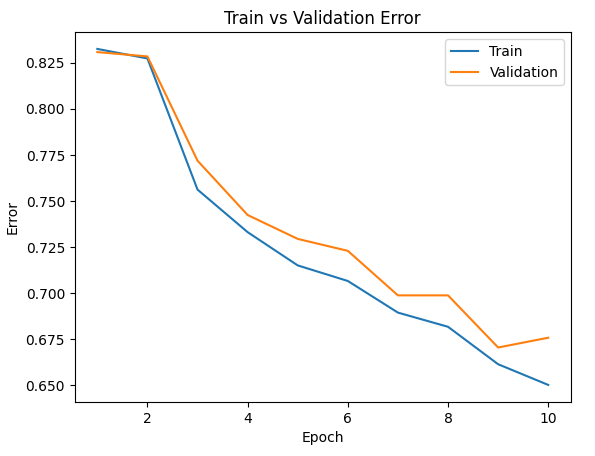

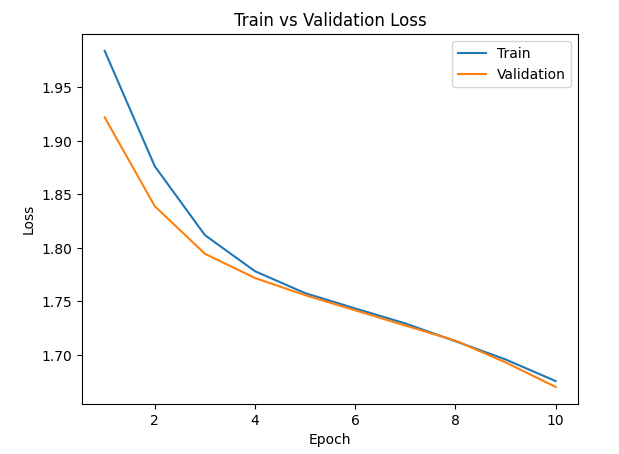